In [5]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import re
import urllib.request

## 1. 관련도 분류 데이터 불러오기 및 전처리

In [6]:
car_data = pd.read_csv('현대+쏘나타_label.csv')
car_data = car_data.drop(['likes'], axis = 1)
print('전체 리뷰 개수 :',len(car_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 3037


In [7]:
train_data_car, test_data_car = train_test_split(car_data, test_size = 0.2, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data_car))
print('테스트용 리뷰의 개수 :', len(test_data_car))

훈련용 리뷰의 개수 : 2429
테스트용 리뷰의 개수 : 608


In [8]:
# 데이터 확인
train_data_car.head()

,Unnamed: 0,comments,label
227,227,계기판 네이게이션 공조정보 내부기능부터 장난 아니구나 이 차는 내 k7는 완전 퇴물...,0
365,365,구독자들 오해하겠어요13:45 에어컨 꺼줘 하니까 a/c 버튼에 불이 꺼졌어요~...,1
2925,2925,이거 소나타 풀체인지 모델인거죠?,1
2501,2501,난 진짜 괜찮은데.... 소나타 중에 이게 잴 나음,0
2001,2001,그냥 보조베터리 하나더 교체하는게 더 나은거 아닙니까 ㅜ 솔라루프 충전량 정말 적...,0


In [9]:
test_data_car.head()

,Unnamed: 0,comments,label
1721,1721,황금 마티즈~ 은근히 현빠이신듯~ 말투가 달라지는것이 티나요~!,1
2334,2334,믿고 보는 한상기님 고맙습니다.,1
443,443,앞모습이 아쉽네요~ 뉴아반떼 느낌이 드네요 딴건 다 개안네요,0
2332,2332,얘 디자인은 되게 애매한거 같음. 완전 정면에서 보면 랜더링에서 본게 그대로 보여서...,0
2883,2883,"말리부랑 소나타 구매를 고민하고 있는데, 패밀리카로 추천하자면 어떤 것을 추천하시겠...",1


In [10]:
train_data_car.drop_duplicates(subset=['comments'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [11]:
print('총 샘플의 수 :',len(train_data_car))

총 샘플의 수 : 2418


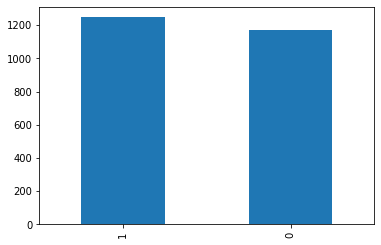

In [12]:
train_data_car['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data_car.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1171
1      1   1247


In [14]:
print(train_data_car.isnull().values.any())

False


In [15]:
print(train_data_car.isnull().sum())

Unnamed: 0    0
comments      0
label         0
dtype: int64


In [16]:
train_data_car.loc[train_data_car.comments.isnull()]


,Unnamed: 0,comments,label


In [17]:
train_data = train_data_car.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [18]:
print(len(train_data_car))


2418


## 2.1 토크나이저를 이용한 정수 인코딩

In [19]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 33.9 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
import transformers

transformers.__version__

'4.19.2'

In [21]:
from transformers import BertTokenizerFast

# BERT tokennizer 모델 다운
tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [22]:
test_data_car = test_data_car.dropna(how = 'any')

In [23]:
print(len(test_data_car))

608


In [24]:
# list로 변환
X_train_list = train_data_car['comments'].tolist()
X_test_list = test_data_car['comments'].tolist()
y_train = train_data_car['label'].tolist()
y_test = test_data_car['label'].tolist()

In [25]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [26]:
print(X_train[0])

Encoding(num_tokens=418, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [27]:
print(X_train[0].tokens)

['[CLS]', '계기', '##판', '네이', '##게이션', '공조', '##정보', '내부', '##기능', '##부터', '장난', '아니', '##구나', '이', '차', '##는', '내', 'k', '##7', '##는', '완전', '퇴', '##물', '##되', '##어가', '##네', '16', '##년', '3', '.', '3', '노스', '##인', '##데', '.', '.', '.', 'ㅠㅠ', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [28]:
print(X_train[0].ids)

[2, 4944, 2025, 6636, 16929, 10161, 19861, 4492, 18159, 3797, 6529, 3614, 6074, 1504, 1632, 2259, 732, 78, 2254, 2259, 5124, 1800, 2266, 2496, 26271, 2203, 3879, 2440, 23, 18, 23, 12192, 2179, 2147, 18, 18, 18, 6516, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [29]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [30]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## 데이터셋 생성 및 모델 학습

In [31]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [32]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(418,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(418,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(418,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [33]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy()

In [35]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.compute_loss

<bound method TFPreTrainedModel.compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7f0251668b90>>

In [43]:
callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(10000).batch(15), epochs=3, batch_size=15,
    validation_data = val_dataset.shuffle(10000).batch(15),
    callbacks = [callback_earlystop]
)

Epoch 1/3
162/162 [==============================] - 242s 1s/step - loss: 6.7587 - accuracy: 0.4835 - val_loss: 3.8238 - val_accuracy: 0.4704
Epoch 2/3
162/162 [==============================] - 241s 1s/step - loss: 6.8641 - accuracy: 0.5215 - val_loss: 7.1732 - val_accuracy: 0.5362
Epoch 3/3
162/162 [==============================] - 240s 1s/step - loss: 7.3850 - accuracy: 0.5426 - val_loss: 7.1732 - val_accuracy: 0.5362


In [44]:
model.evaluate(val_dataset.batch(64))

10/10 [==============================] - 17s 2s/step - loss: 7.1732 - accuracy: 0.5362


[7.173161506652832, 0.5361841917037964]

## 모델 저장

In [ ]:
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

## 모델 로드 및 테스트

In [ ]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

In [ ]:
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]